In [1]:
from EPInformer.models import enhancer_predictor_256bp
import torch
from scripts.utils import one_hot_encode, predict_enhancer_activity

In [2]:
from tangermeme.ism import saturation_mutagenesis
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_style('white')
from tangermeme.plot import plot_logo

import pandas as pd
import numpy as np
from scipy import stats

## Predict enhancer activity and dicover TF motifs at CRISPRi-validated enhancer of KLF1 in K562

In [3]:
# Load CRISPRi-FlowFISH data
flowfish_df = pd.read_excel('./data/CRISPRi-FlowFISH_Fulco2019/41588_2019_538_MOESM3_ESM.xlsx',sheet_name='Supplementary Table 6a', skiprows=[0])
flowfish_df['mid'] = flowfish_df['start'] + (flowfish_df['end'] - flowfish_df['start'])/2
flowfish_df['Distance_withDirect'] = flowfish_df['mid'] - flowfish_df['Gene TSS']
flowfish_df['Distance'] = np.abs(flowfish_df['Distance_withDirect'])
flowfish_100kb_df = flowfish_df[flowfish_df['Distance']<100_000]
# CRISPRi-validated enhancer regions for KLF1
KLF1_validated_enhancers = flowfish_100kb_df[(flowfish_100kb_df['Gene']=='KLF1')&(flowfish_100kb_df['Significant'])&(flowfish_100kb_df['Fraction change in gene expr']<0)].reset_index()

In [4]:
KLF1_validated_enhancers[['chr', 'start', 'end', 'mid', 'Gene TSS', 'Distance_withDirect', 'Fraction change in gene expr']]

,chr,start,end,mid,Gene TSS,Distance_withDirect,Fraction change in gene expr
0,chr19,12958325,12958825,12958575.0,12998017,-39442.0,-0.057784
1,chr19,12977965,12978745,12978355.0,12998017,-19662.0,-0.026087
2,chr19,12992085,12992645,12992365.0,12998017,-5652.0,-0.161863
3,chr19,12999705,13000205,12999955.0,12998017,1938.0,-0.169294
4,chr19,13001505,13002192,13001848.5,12998017,3831.5,-0.124012


In [6]:
enhancer_locus = KLF1_validated_enhancers.iloc[1]['mid']
enhancer_chrom = KLF1_validated_enhancers.iloc[1]['chr']
# Load enhancer activity predictor
device = 'cpu'
net = enhancer_predictor_256bp().to(device)
pt_model_name = 'K562_seq2activityLog2_leaveChrOut_combinedRS_2bins_bs64_H3K27ac_adamW_erisxdl_r0'
checkpoint = torch.load("./trained_models/pretrained_enhancer_encoder/fold_8_best_" + pt_model_name + "_checkpoint.pt", map_location=torch.device('cpu'), weights_only=False)
net.load_state_dict(checkpoint['model_state_dict'])
# Predict enhancer activity
pred_info = predict_enhancer_activity(net, enhancer_chrom, int(enhancer_locus), window_size=512+256, stride=128, device='cpu')

The extened enhancer region: chr19:12977587-12979123


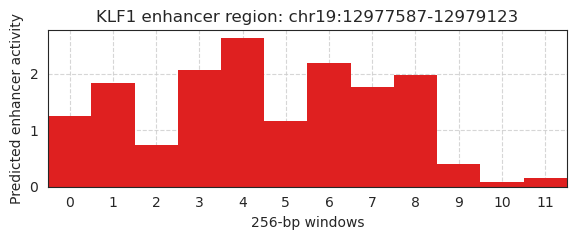

In [7]:
plt.figure(figsize=(6, 2.5))
sns.barplot(x=pred_info.index, y='pred', data=pred_info, color='red', width=1, linewidth=0)
plt.grid(linestyle='--', alpha=0.8)
plt.ylabel('Predicted enhancer activity')
plt.xlabel('256-bp windows')
plt.title('KLF1 enhancer region: chr19:12977587-12979123')
plt.tight_layout()

In [8]:
# calculate ISM score for the top 256-bp window
top_activity_256bp = pred_info.sort_values(by='pred', ascending=False).iloc[0] # top 256-bp window
seq_ohe = one_hot_encode(top_activity_256bp.seq)
seq_tensor = torch.from_numpy(seq_ohe).unsqueeze(0).permute(0, 2, 1)
seq_ISM = saturation_mutagenesis(net, seq_tensor, device='cpu')

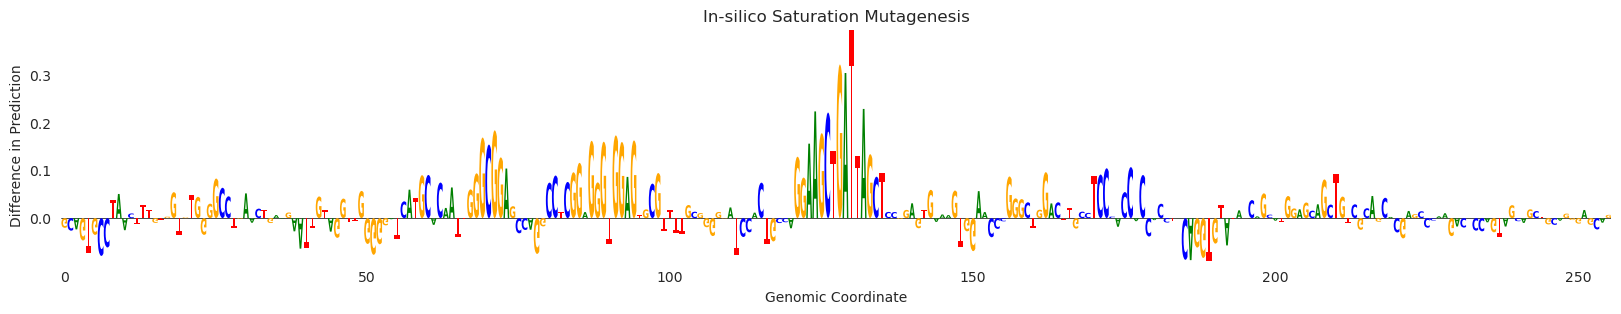

In [9]:
plt.figure(figsize=(20, 3))
ax = plt.subplot(111)
plot_logo(seq_ISM[0], ax=ax)
plt.xlabel("Genomic Coordinate")
plt.ylabel("Difference in Prediction")
plt.title("In-silico Saturation Mutagenesis")
plt.show()

## 12-fold Cross-chromosome evaluation performance in K562

In [10]:
all_dfs = []
for fi in range(1, 13):
    fn = './trained_models/pretrained_enhancer_encoder/fold_{}_K562_seq2activityLog2_leaveChrOut_combinedRS_2bins_bs64_H3K27ac_adamW_erisxdl_r0_predictions.csv'.format(fi)
    activity_df = pd.read_csv(fn)
    # print(fi, stats.pearsonr(activity_df['Pred'], activity_df['actual']))
    all_dfs.append(activity_df)
all_dfs = pd.concat(all_dfs).set_index('Unnamed: 0')
pearsonR, pv = stats.pearsonr(all_dfs['Pred'], all_dfs['actual'])
print(pearsonR)

0.7095633017715988


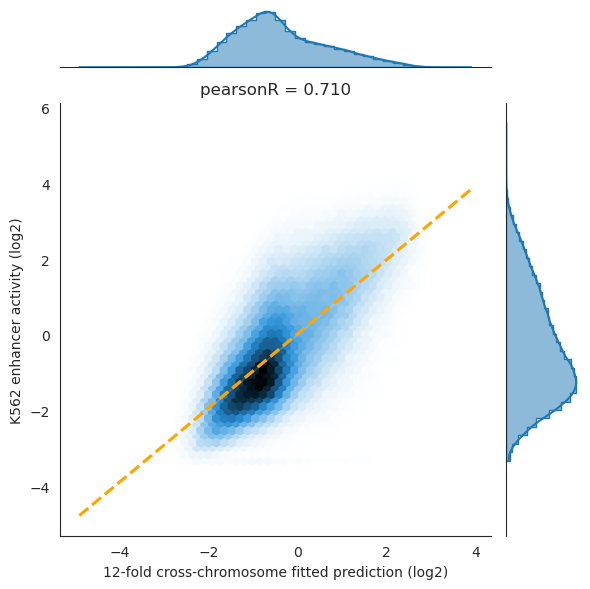

In [11]:
ax = sns.jointplot(data=all_dfs,x="Pred", y="actual",
               kind="hex", marginal_kws={'bins':40, 'element':'step', 'kde':True}) 
ax.plot_joint(sns.regplot, color="r", scatter=False, line_kws={"color": "orange", 'linestyle':'dashed'})
plt.title('pearsonR = {:.3f}'.format(pearsonR))
plt.ylabel('K562 enhancer activity (log2)')
plt.xlabel('12-fold cross-chromosome fitted prediction (log2)')
plt.tight_layout()
# plt.savefig('./figures/K562_enhancer_preds.pdf', transparent=True)